In [19]:
## Planned datasets - Image (different image sizes/ Different number of classes), 
##                    Classification (Different feature size / Different number of classes)

## Planned models - FC/Dropout, CNN(LeNet)/Resnet/Inception (Maybe include attention)

## Predict running time based on Layers/No of params/FLOPs
## Calculate total number of computations (based on dataset/model size)
## Calculate approx cost on GCP (or any cloud platform)

import tensorflow as tf
import numpy as np

In [31]:
def create_fc(config):
    config['hidden_layers'] = len(config['layers'])
    input = tf.keras.layers.Input(shape=config['input_shape'])
    if config['input_dropout'] is not None:
        x = tf.keras.layers.Dropout(config['input_dropout'])(input)
    else:
        x = input
    for i in range(config['hidden_layers']):
        dim = config['layers'][i]
        act = 'relu'
        x = tf.keras.layers.Dense(dim,activation=act)(x)
        if config['dropout'] is not None:
            x = tf.keras.layers.Dropout(config['dropout'])(x)
            
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Dense(config['output_shape'],activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=x)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                                metrics=['accuracy'])
    return model

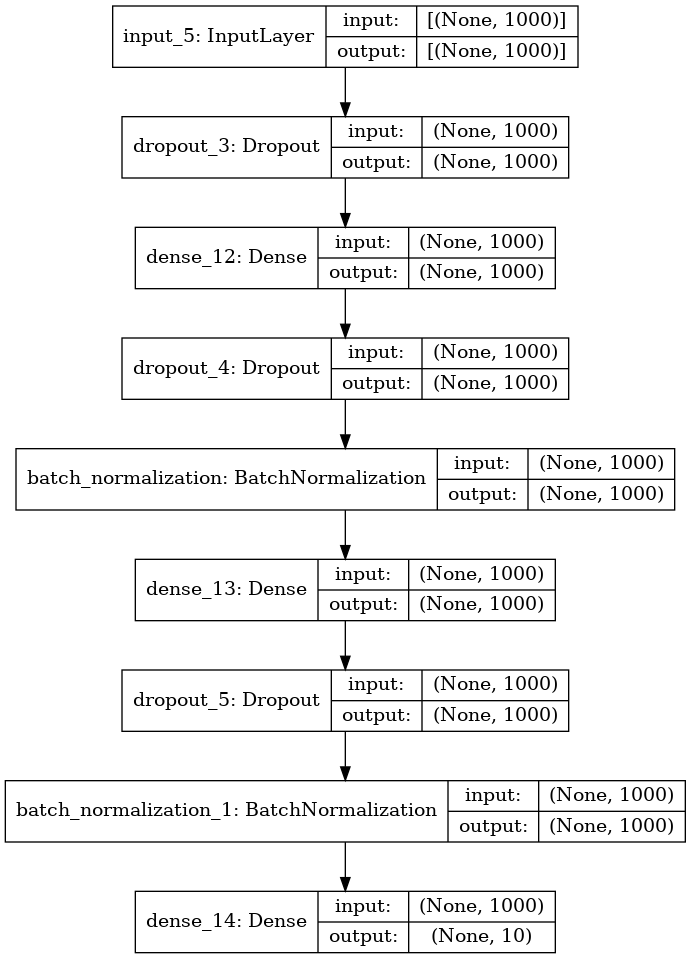

In [32]:
fc_config = dict()
fc_config['input_shape'] = 1000
fc_config['output_shape'] = 10
fc_config['input_dropout'] = 0.2
fc_config['dropout'] = 0.5
fc_config['hidden_layers'] = 2
fc_config['layers'] = [1000,1000]
# Output activation = always sigmoid
# All hidden layers have same dropout
# All hidden layers activated with ReLU
# Optimizer is always sgd with lr = 0.01 and momentum=0.9

fc_model = create_fc(fc_config)

tf.keras.utils.plot_model(fc_model,show_shapes=True)

In [33]:
def vgg_block(x, filters, layers):
    for _ in range(layers):
        x = tf.keras.layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2,2), strides=(2,2))(x)
    return x

def create_vgg(config):
    config['num_layers'] = len(config['vgg_layers'])
    input = tf.keras.layers.Input(shape=config['input_shape'])
    x = input
    for i in range(config['num_layers']):
        block_size = config['vgg_layers'][i]
        filter_num = config['filters'][i]
        act = 'relu'
        x = vgg_block(x,filter_num,block_size)
    x = tf.keras.layers.Flatten()(x)
    config['num_hidden_layers'] = len(config['hidden_layers'])
    for i in range(config['num_hidden_layers']):
        dim = config['hidden_layers'][i]
        act = 'relu'
        x = tf.keras.layers.Dense(dim,activation=act)(x)

    x = tf.keras.layers.Dense(config['output_shape'],activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=x)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                                metrics=['accuracy'])
    return model

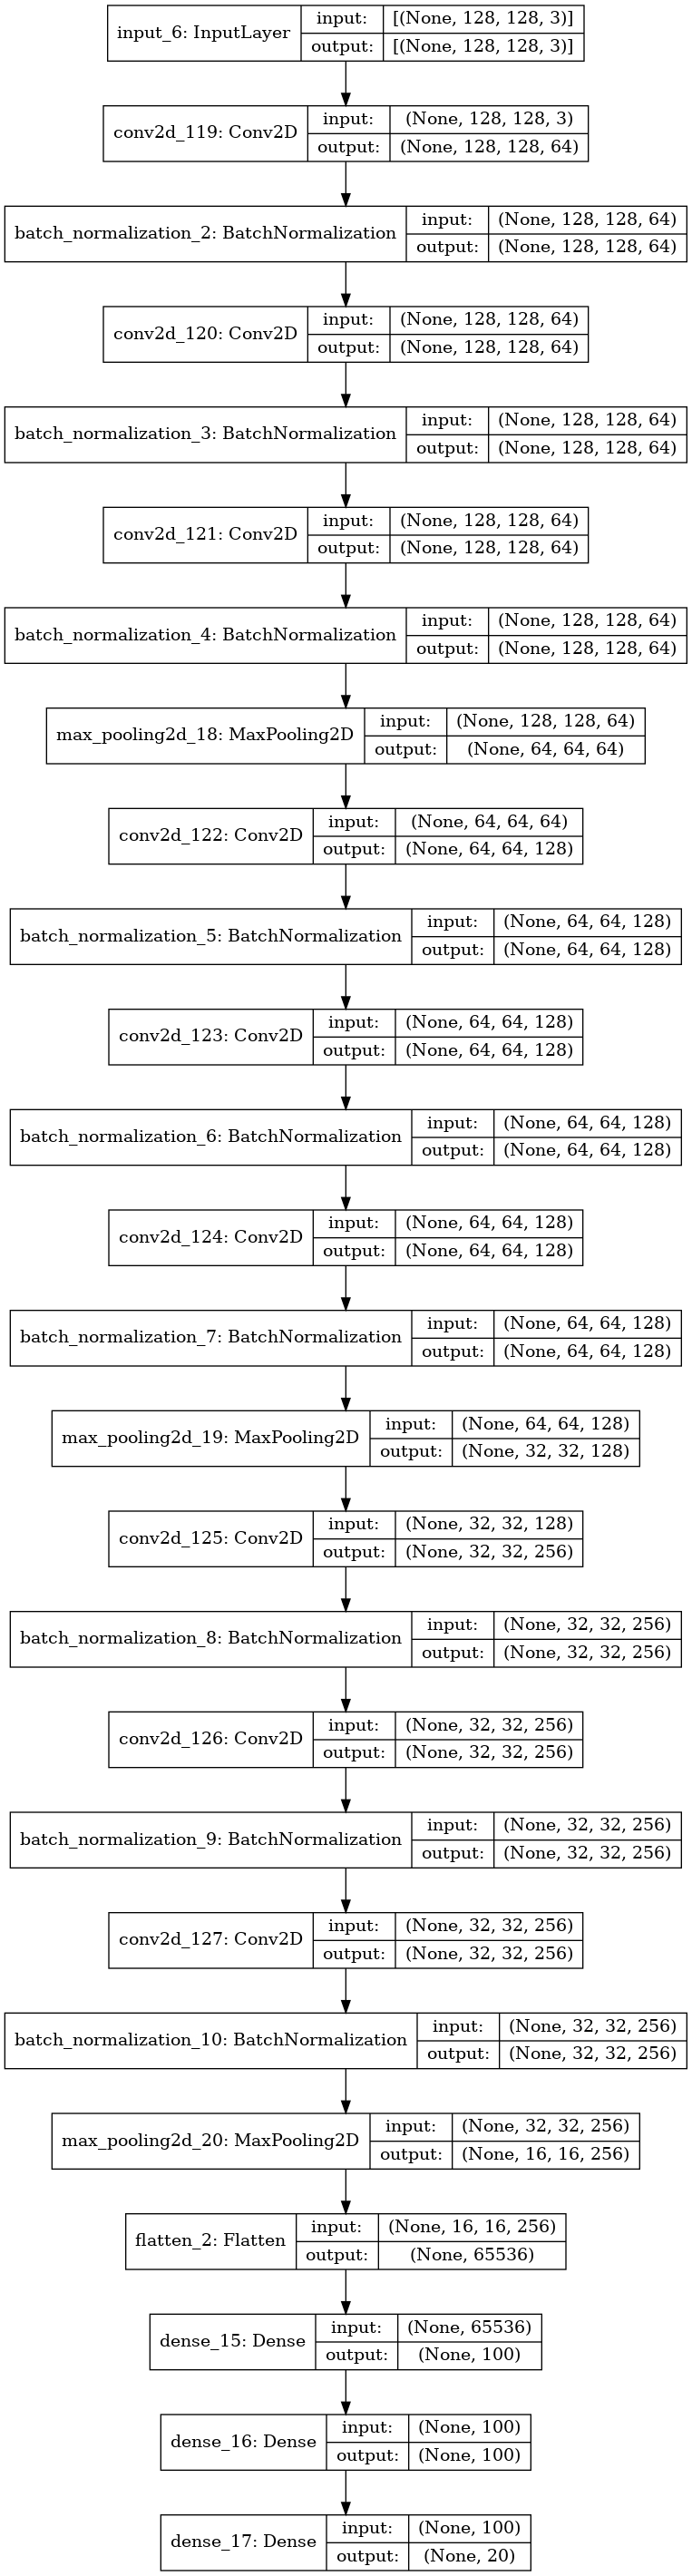

In [34]:
vgg_config = dict()
vgg_config['input_shape'] = (128,128,3)
vgg_config['vgg_layers'] = [3,3,3]
vgg_config['filters'] = [64,128,256]
vgg_config['hidden_layers'] = [100,100]
vgg_config['output_shape'] = 20
# Output activation = always sigmoid
# All convolution layers have 3x3 kernel and same padding
# All pooling layers (end of VGG block) reduce image size by half
# All hidden layers activated with ReLU
# Optimizer is always sgd with lr = 0.01 and momentum=0.9

vgg_model = create_vgg(vgg_config)

tf.keras.utils.plot_model(vgg_model,show_shapes=True)

In [35]:
def inception_block(x, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = tf.keras.layers.Conv2D(f1, (1,1), padding='same', activation='relu')(x)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    # 3x3 conv
    conv3 = tf.keras.layers.Conv2D(f2_in, (1,1), padding='same', activation='relu')(x)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    # 5x5 conv
    conv5 = tf.keras.layers.Conv2D(f3_in, (1,1), padding='same', activation='relu')(x)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = tf.keras.layers.Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    # 3x3 max pooling
    pool = tf.keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    pool = tf.keras.layers.Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    pool = tf.keras.layers.BatchNormalization()(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = tf.keras.layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

def create_inception(config):
    config['num_layers'] = len(config['inception_layers'])
    input = tf.keras.layers.Input(shape=config['input_shape'])
    x = tf.keras.layers.Conv2D(64, (7,7), padding='valid', activation='relu', strides=(2,2))(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    x = tf.keras.layers.Conv2D(128, (1,1), padding='same', activation='relu', strides=(1,1))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(192, (3,3), padding='same', activation='relu', strides=(1,1))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    for i in range(config['num_layers']):
        for j in range(config['inception_layers'][i]):
            x = inception_block(x,config['f1'][i][j],config['f2_in'][i][j],config['f2_out'][i][j],
                                                    config['f3_in'][i][j],config['f3_out'][i][j],config['f4_out'][i][j])
        x = tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    config['num_hidden_layers'] = len(config['hidden_layers'])
    for i in range(config['num_hidden_layers']):
        dim = config['hidden_layers'][i]
        act = 'relu'
        x = tf.keras.layers.Dense(dim,activation=act)(x)

    x = tf.keras.layers.Dense(config['output_shape'],activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=x)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                                metrics=['accuracy'])
    return model

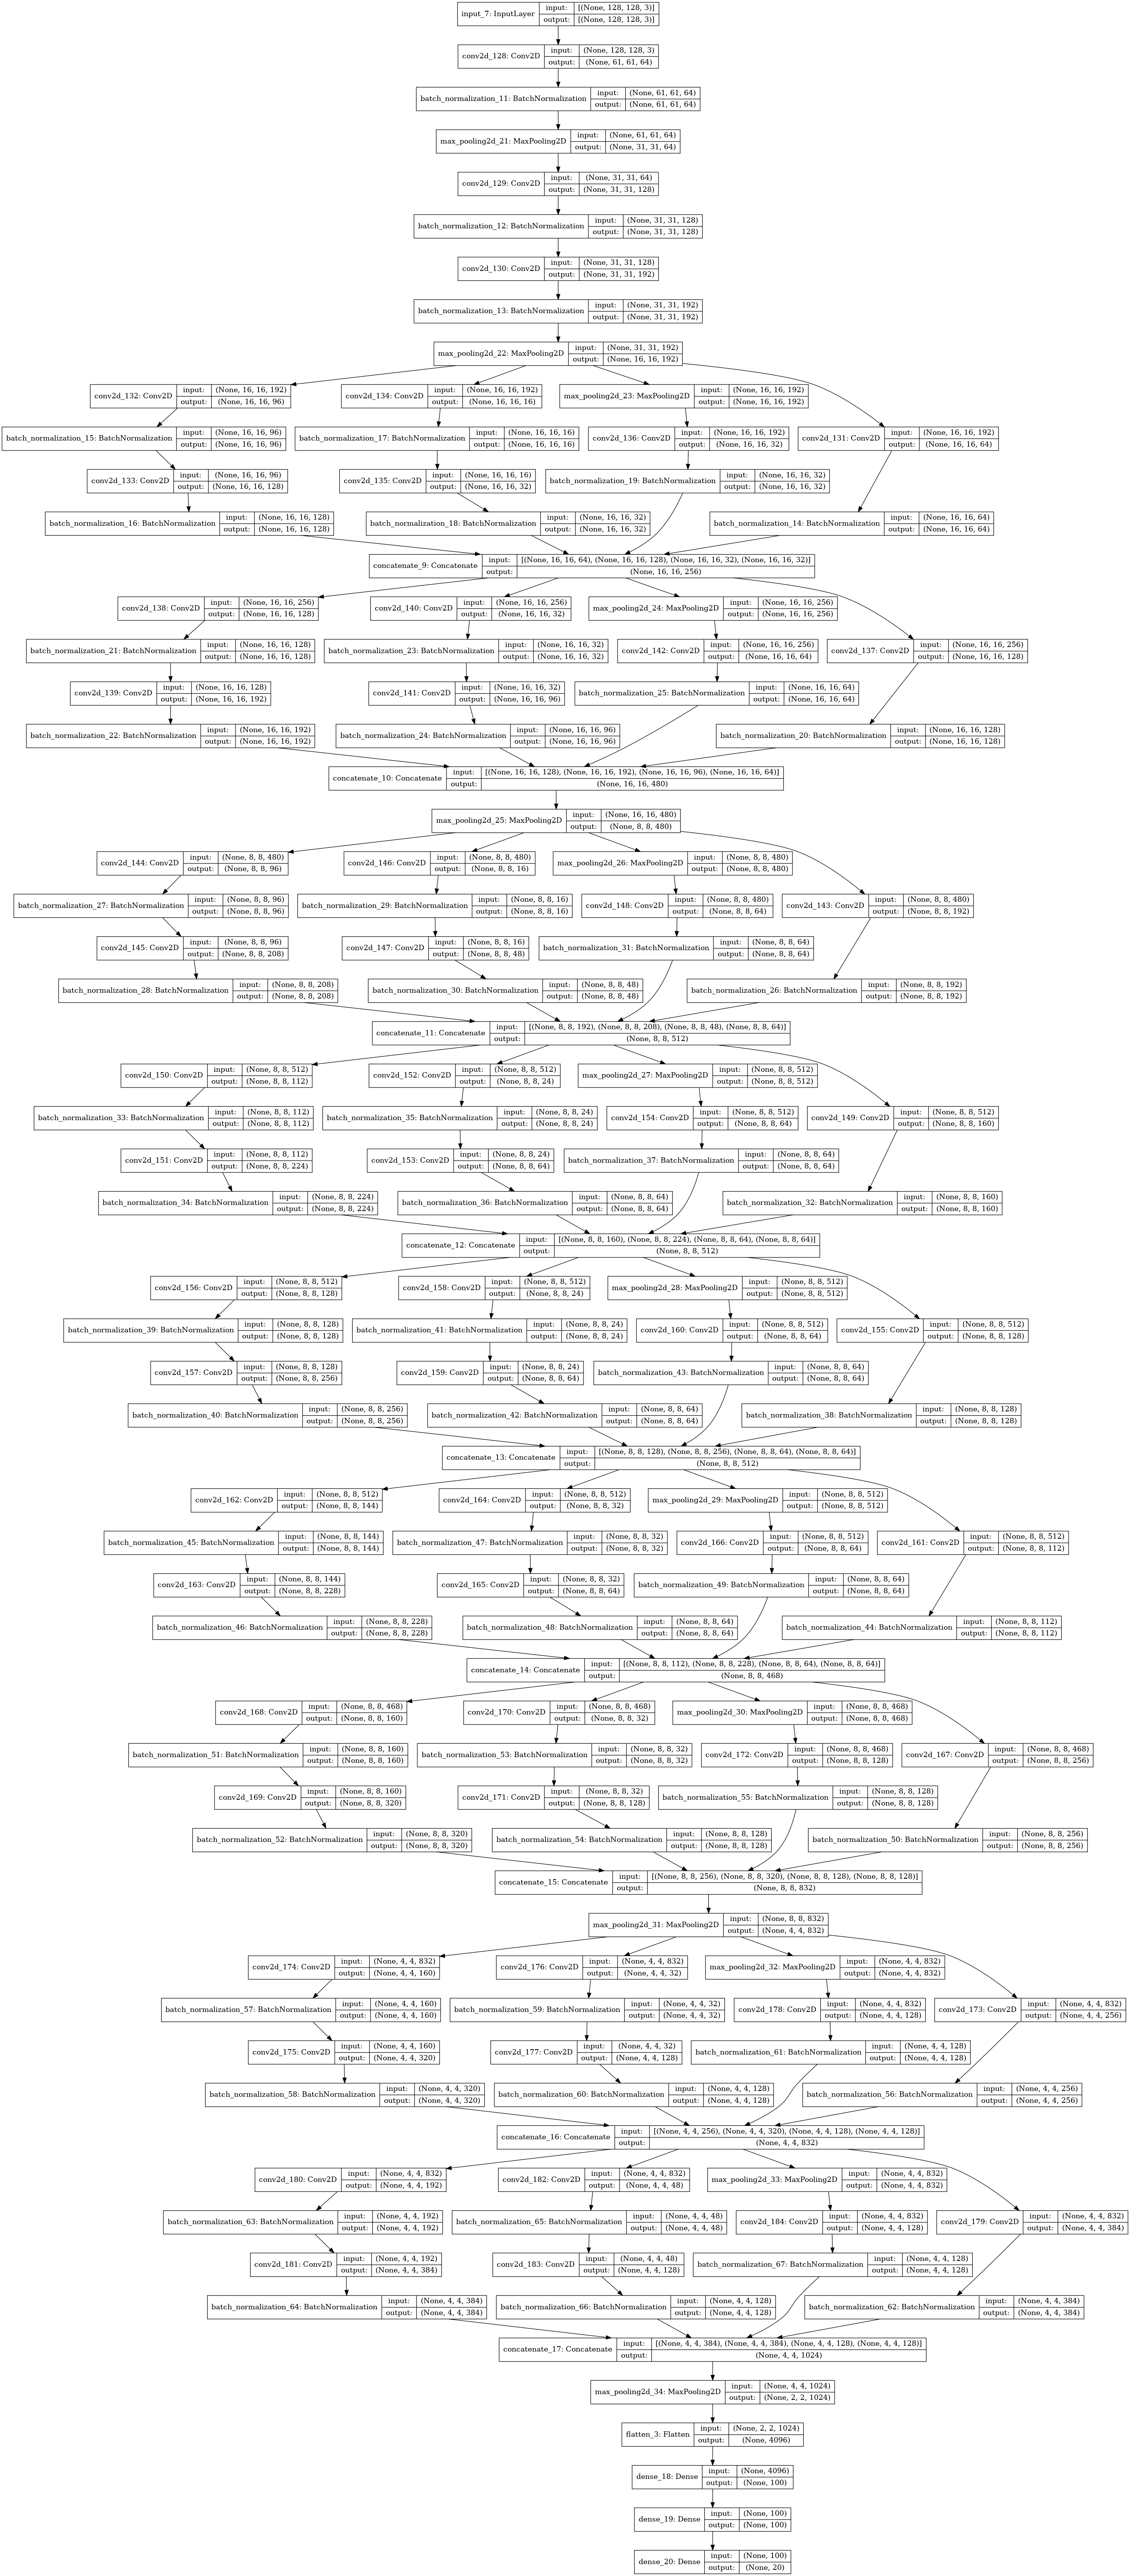

In [36]:
inception_config = dict()
inception_config['input_shape'] = (128,128,3)
inception_config['inception_layers'] = [2,5,2]
inception_config['f1'] = [[64,128],[192,160,128,112,256],[256,384]]
inception_config['f2_in'] = [[96,128],[96,112,128,144,160],[160,192]]
inception_config['f2_out'] = [[128,192],[208,224,256,228,320],[320,384]]
inception_config['f3_in'] = [[16,32],[16,24,24,32,32],[32,48]]
inception_config['f3_out'] = [[32,96],[48,64,64,64,128],[128,128]]
inception_config['f4_out'] = [[32,64],[64,64,64,64,128],[128,128]]
inception_config['hidden_layers'] = [100,100]
inception_config['output_shape'] = 20
# Output activation = always sigmoid
# All convolution layers have 3x3 kernel and same padding
# All pooling layers (end of VGG block) reduce image size by half
# All hidden layers activated with ReLU
# Optimizer is always sgd with lr = 0.01 and momentum=0.9

inception_model = create_inception(inception_config)

tf.keras.utils.plot_model(inception_model,show_shapes=True)

In [37]:
def conv_relu(x, filters, kernel_size, strides=1):
        
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding = 'same')(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.BatchNormalization()(x)
        return x

def identity_block(tensor, filters):
        
        x = conv_relu(tensor, filters=filters, kernel_size=1, strides=1)
        x = conv_relu(x, filters=filters, kernel_size=3, strides=1)
        x = tf.keras.layers.Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = tf.keras.layers.Add()([tensor,x])
        x = tf.keras.layers.ReLU()(x)
        
        return x

def identity_block_small(tensor, filters):
        
        x = conv_relu(tensor, filters=filters, kernel_size=3, strides=1)
        x = conv_relu(x, filters=filters, kernel_size=3, strides=1)
        
        x = tf.keras.layers.Add()([tensor,x])
        x = tf.keras.layers.ReLU()(x)
        
        return x

def projection_block(tensor, filters, strides):
        
        x = conv_relu(tensor, filters=filters, kernel_size=1, strides=strides)
        x = conv_relu(x, filters=filters, kernel_size=3, strides=1)
        x = tf.keras.layers.Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        shortcut = tf.keras.layers.Conv2D(filters=4*filters, kernel_size=1, strides=strides)(tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = tf.keras.layers.Add()([shortcut,x])
        x = tf.keras.layers.ReLU()(x)
        
        return x

def projection_block_small(tensor, filters, strides):
        
        x = conv_relu(tensor, filters=filters, kernel_size=3, strides=strides)
        x = conv_relu(x, filters=filters, kernel_size=3, strides=1)
        
        shortcut = tf.keras.layers.Conv2D(filters=filters, kernel_size=1, strides=strides)(tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = tf.keras.layers.Add()([shortcut,x])
        x = tf.keras.layers.ReLU()(x)
        
        return x

def resnet_block(x, filters, reps, strides):
        
        x = projection_block(x, filters, strides)
        for _ in range(reps-1):
                x = identity_block(x,filters)
                
        return x

def resnet_block_small(x, filters, reps, strides):
        
        x = projection_block_small(x, filters, strides)
        for _ in range(reps):
                x = identity_block_small(x,filters)
                
        return x

def resnet(config):

    input = tf.keras.layers.Input(shape=config['input_shape'])

    x = conv_relu(input, filters=64, kernel_size=7, strides=2)
    x = tf.keras.layers.MaxPool2D(pool_size = 3, strides =2)(x)
    if config['small']==False:
            x = resnet_block(x, filters=64, reps=config['resnet_layers'][0], strides=1)
            x = resnet_block(x, filters=128, reps=config['resnet_layers'][1], strides=2)
            x = resnet_block(x, filters=256, reps=config['resnet_layers'][2], strides=2)
            x = resnet_block(x, filters=512, reps=config['resnet_layers'][3], strides=2)
    else:
            x = resnet_block_small(x, filters=64, reps=config['resnet_layers'][0], strides=1)
            x = resnet_block_small(x, filters=128, reps=config['resnet_layers'][1], strides=2)
            x = resnet_block_small(x, filters=256, reps=config['resnet_layers'][2], strides=2)
            x = resnet_block_small(x, filters=512, reps=config['resnet_layers'][3], strides=2)
    x = tf.keras.layers.GlobalAvgPool2D()(x)

    config['num_hidden_layers'] = len(config['hidden_layers'])
    for i in range(config['num_hidden_layers']):
        dim = config['hidden_layers'][i]
        act = 'relu'
        x = tf.keras.layers.Dense(dim,activation=act)(x)

    output = tf.keras.layers.Dense(config['output_shape'], activation ='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                            optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                            metrics=['accuracy'])
    return model

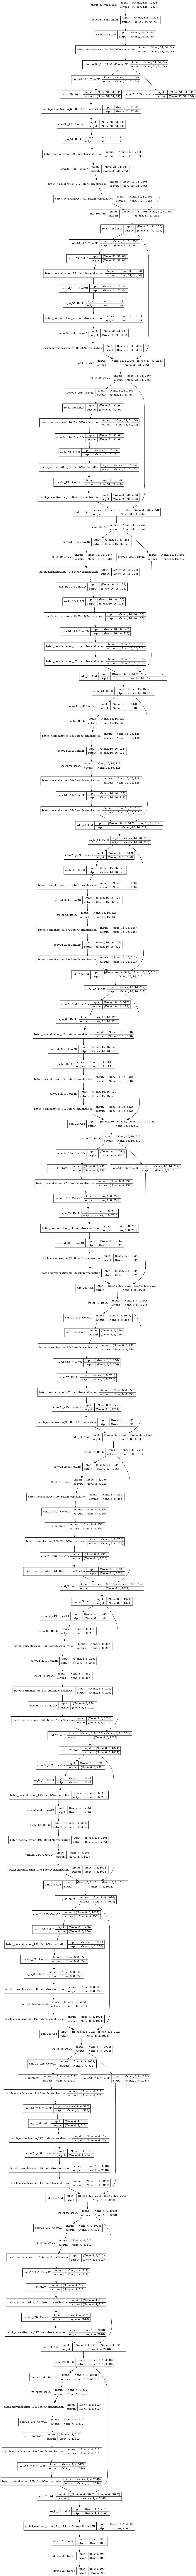

In [38]:
resnet_config = dict()
resnet_config['input_shape'] = (128,128,3)
resnet_config['small'] = False
resnet_config['resnet_layers'] = [3,4,6,3]
resnet_config['hidden_layers'] = [100,100]
resnet_config['output_shape'] = 20
resnet_model = resnet(resnet_config)
# Output activation = always sigmoid
# All resnet blocks have same structure. Can only specify number of repeating blocks (4 list)
# Can also specify if small architecture or not (refer paper)
# All hidden layers activated with ReLU
# Optimizer is always sgd with lr = 0.01 and momentum=0.9

tf.keras.utils.plot_model(resnet_model,show_shapes=True)

In [60]:
tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()['output']

'stdout'

In [61]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

def get_flops(model, batch_size=None):
    if batch_size is None:
        batch_size = 1

    real_model = tf.function(model).get_concrete_function(tf.TensorSpec([batch_size] + model.inputs[0].shape[1:], model.inputs[0].dtype))
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(real_model)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    opts['output'] = 'none'
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                            run_meta=run_meta, cmd='op', options=opts)
    return flops

In [62]:
fc_flops = get_flops(fc_model, batch_size=1)
vgg_flops = get_flops(vgg_model, batch_size=1)
inception_flops = get_flops(inception_model, batch_size=1)
resnet_flops = get_flops(resnet_model, batch_size=1)

2021-12-04 02:08:11.682158: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2021-12-04 02:08:11.682740: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-12-04 02:08:11.686680: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38464 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0
2021-12-04 02:08:11.691761: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.053ms.
  function_optimizer: function_optimizer did nothing. time = 0.003ms.

2021-12-04 02:08:11.895239: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2021-12-04 02:08:11.895379: I tensorflow/core/grappler/clusters/s

In [63]:
x = fc_flops.children
while(len(x) > 0):
    print(x[0].name,x[0].total_float_ops)
    x = x[0].children

MatMul 4034060
Mul 14060
Rsqrt 8060
BiasAdd 4060
Sub 2050
Softmax 50


In [64]:
x = vgg_flops.children
while(len(x) > 0):
    print(x[0].name,x[0].total_float_ops)
    x = x[0].children

Conv2D 8532811520
MatMul 20471552
BiasAdd 7340352
MaxPool 1835108
Softmax 100


In [65]:
x = resnet_flops.children
while(len(x) > 0):
    print(x[0].name,x[0].total_float_ops)
    x = x[0].children

Conv2D 2495706816
BiasAdd 4388544
MaxPool 1020004
MatMul 466468
Mean 32868
Softmax 100


In [67]:
x = inception_flops.children
while(len(x) > 0):
    print(x[0].name,x[0].total_float_ops)
    x = x[0].children

Conv2D 1223505728
MaxPool 6046144
BiasAdd 1914496
MatMul 843300
Softmax 100


In [68]:
def get_weights(model):
    print("Trainable Weights : ",np.sum([np.product([xi for xi in x.get_shape()]) for x in model.trainable_weights]))
    print("Non Trainable Weights : ",np.sum([np.product([xi for xi in x.get_shape()]) for x in model.non_trainable_weights]))
    print("___")

In [69]:
get_weights(fc_model)
get_weights(resnet_model)
get_weights(inception_model)
get_weights(vgg_model)

Trainable Weights :  2016010
Non Trainable Weights :  4000
___
Trainable Weights :  23751612
Non Trainable Weights :  53120
___
Trainable Weights :  6412312
Non Trainable Weights :  14568
___
Trainable Weights :  8488508
Non Trainable Weights :  2688
___


In [49]:
def get_layers(model):
    for l in model.layers:
        w = np.sum([np.product([xi for xi in x.get_shape()]) for x in l.weights])
        if w > 0:
            print(l.name)

In [50]:
get_layers(fc_model)

dense_12
batch_normalization
dense_13
batch_normalization_1
dense_14


In [51]:
get_layers(resnet_model)

conv2d_185
batch_normalization_68
conv2d_186
batch_normalization_69
conv2d_187
batch_normalization_70
conv2d_188
batch_normalization_71
conv2d_189
batch_normalization_72
conv2d_190
batch_normalization_73
conv2d_191
batch_normalization_74
conv2d_192
batch_normalization_75
conv2d_193
batch_normalization_76
conv2d_194
batch_normalization_77
conv2d_195
batch_normalization_78
conv2d_196
batch_normalization_79
conv2d_197
batch_normalization_80
conv2d_198
batch_normalization_81
conv2d_199
batch_normalization_82
conv2d_200
batch_normalization_83
conv2d_201
batch_normalization_84
conv2d_202
batch_normalization_85
conv2d_203
batch_normalization_86
conv2d_204
batch_normalization_87
conv2d_205
batch_normalization_88
conv2d_206
batch_normalization_89
conv2d_207
batch_normalization_90
conv2d_208
batch_normalization_91
conv2d_209
batch_normalization_92
conv2d_210
batch_normalization_93
conv2d_211
batch_normalization_94
conv2d_212
batch_normalization_95
conv2d_213
batch_normalization_96
conv2d_214
bat

In [52]:
get_layers(inception_model)

conv2d_128
batch_normalization_11
conv2d_129
batch_normalization_12
conv2d_130
batch_normalization_13
conv2d_132
conv2d_134
batch_normalization_15
batch_normalization_17
conv2d_131
conv2d_133
conv2d_135
conv2d_136
batch_normalization_14
batch_normalization_16
batch_normalization_18
batch_normalization_19
conv2d_138
conv2d_140
batch_normalization_21
batch_normalization_23
conv2d_137
conv2d_139
conv2d_141
conv2d_142
batch_normalization_20
batch_normalization_22
batch_normalization_24
batch_normalization_25
conv2d_144
conv2d_146
batch_normalization_27
batch_normalization_29
conv2d_143
conv2d_145
conv2d_147
conv2d_148
batch_normalization_26
batch_normalization_28
batch_normalization_30
batch_normalization_31
conv2d_150
conv2d_152
batch_normalization_33
batch_normalization_35
conv2d_149
conv2d_151
conv2d_153
conv2d_154
batch_normalization_32
batch_normalization_34
batch_normalization_36
batch_normalization_37
conv2d_156
conv2d_158
batch_normalization_39
batch_normalization_41
conv2d_155
con

In [53]:
get_layers(vgg_model)

conv2d_119
batch_normalization_2
conv2d_120
batch_normalization_3
conv2d_121
batch_normalization_4
conv2d_122
batch_normalization_5
conv2d_123
batch_normalization_6
conv2d_124
batch_normalization_7
conv2d_125
batch_normalization_8
conv2d_126
batch_normalization_9
conv2d_127
batch_normalization_10
dense_15
dense_16
dense_17


### Planned parameters : 

1. Number of cov layers
2. Number of dense layers
3. Number of total layers

4. Conv2D flops
5. MaxPool flops
6. Bias Addition flops
8. Matrix Multiplication flops
7. Mean Flops
8. Softmax Flops

9. Dataset shape (image - max(width,height), fc - input dimension)
10. Number of training images
11. Output dimensions
----------
12. Model Type
13. Batch Size

Include Batch norm (after every layer)

### Models

1. Fully connected

fc_config['input_shape'] = 1000 <br>
fc_config['output_shape'] = 10 <br>
fc_config['input_dropout'] = 0.2 <br>
fc_config['dropout'] = 0.5 <br>
fc_config['hidden_layers'] = 2 <br>
fc_config['layers'] = [1000,1000] <br>

2. VGG

vgg_config['input_shape'] = (128,128,3) <br>
vgg_config['vgg_layers'] = [3,3,3] <br>
vgg_config['filters'] = [64,128,256] <br>
vgg_config['hidden_layers'] = [100,100] <br>
vgg_config['output_shape'] = 20 <br>

3. Inception Network

inception_config['input_shape'] = (128,128,3) <br>
inception_config['inception_layers'] = [2,5,2] <br>
inception_config['f1'] = [[64,128],[192,160,128,112,256],[256,384]] <br>
inception_config['f2_in'] = [[96,128],[96,112,128,144,160],[160,192]] <br>
inception_config['f2_out'] = [[128,192],[208,224,256,228,320],[320,384]] <br>
inception_config['f3_in'] = [[16,32],[16,24,24,32,32],[32,48]] <br>
inception_config['f3_out'] = [[32,96],[48,64,64,64,128],[128,128]] <br>
inception_config['f4_out'] = [[32,64],[64,64,64,64,128],[128,128]] <br>
inception_config['hidden_layers'] = [100,100] <br>
inception_config['output_shape'] = 20 <br>

4. Resnet

resnet_config['input_shape'] = (128,128,3) <br>
resnet_config['small'] = False <br>
resnet_config['resnet_layers'] = [3,4,6,3] <br>
resnet_config['hidden_layers'] = [100,100] <br>
resnet_config['output_shape'] = 20 <br>
resnet_model = resnet(resnet_config) <br>